In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    make_scorer,
)

In [9]:
path = '../data/steel.csv'
data = pd.read_csv(path)
feature_cols = [
    "normalising_temperature",
    "tempering_temperature",
    "percent_silicon",
    "percent_chromium",
    "percent_copper",
    "percent_nickel",
    "percent_sulphur",
    "percent_carbon",
    "percent_manganese",
]

X = data[feature_cols]
y = data["tensile_strength"]

In [10]:
#scoring setup
mae_scorer = "neg_mean_absolute_error"

mape_scorer = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False,
)

In [11]:
#baseline gb regressor
gbr_default = GradientBoostingRegressor(
    random_state=1,   #same as rf
)

#10-fold cv on baseline model
gbr_cv_default = cross_validate(
    gbr_default,
    X,
    y,
    cv=10,
    scoring={"mae": mae_scorer, "mape": mape_scorer},
    return_train_score=True,
)

#converting negative values
gbr_train_mae = -gbr_cv_default["train_mae"]
gbr_test_mae = -gbr_cv_default["test_mae"]
gbr_train_mape = -gbr_cv_default["train_mape"]
gbr_test_mape = -gbr_cv_default["test_mape"]

print("\n_____Default Hyperparameters (GradientBoostingRegressor)_____")
print(f"Mean TRAIN MAE  over 10 folds: {gbr_train_mae.mean():.3f}")
print(f"Mean TEST  MAE  over 10 folds: {gbr_test_mae.mean():.3f}")
print(f"Mean TRAIN MAPE over 10 folds: {gbr_train_mape.mean():.3f}")
print(f"Mean TEST  MAPE over 10 folds: {gbr_test_mape.mean():.3f}")


_____Default Hyperparameters (GradientBoostingRegressor)_____
Mean TRAIN MAE  over 10 folds: 12.490
Mean TEST  MAE  over 10 folds: 32.413
Mean TRAIN MAPE over 10 folds: 0.076
Mean TEST  MAPE over 10 folds: 0.194


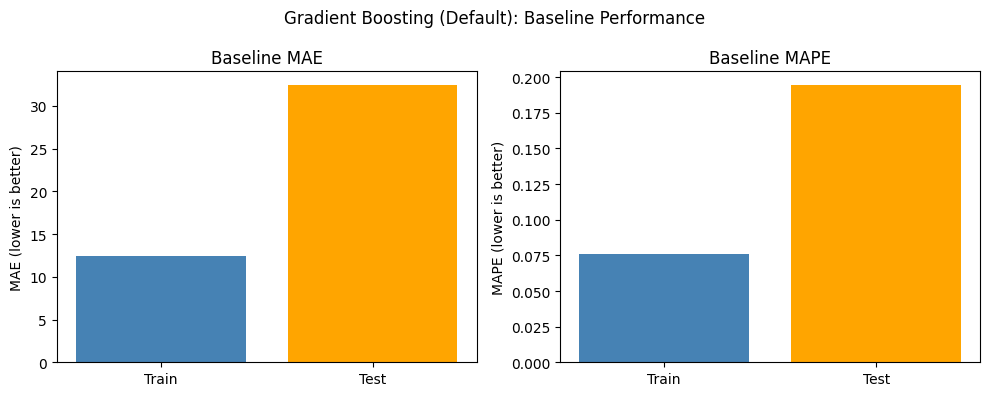

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#MAE plot
axes[0].bar(
    ["Train", "Test"],
    [gbr_train_mae.mean(), gbr_test_mae.mean()],
    color=["steelblue", "orange"]
)
axes[0].set_title("Baseline MAE")
axes[0].set_ylabel("MAE (lower is better)")

#MAPE plot
axes[1].bar(
    ["Train", "Test"],
    [gbr_train_mape.mean(), gbr_test_mape.mean()],
    color=["steelblue", "orange"]
)
axes[1].set_title("Baseline MAPE")
axes[1].set_ylabel("MAPE (lower is better)")

plt.suptitle("Gradient Boosting (Default): Baseline Performance")
plt.tight_layout()
plt.show()

In [24]:
gbr_base = GradientBoostingRegressor(
    random_state=1,
)

#hyperparam tuning
gbr_param_grid = {
    "n_estimators": [25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.075, 0.1, 0.15, 0.25, 0.4],
}

#grid search setup (10-fold cv, same as rf)
gbr_grid = GridSearchCV(
    estimator=gbr_base,
    param_grid=gbr_param_grid,
    cv=10,
    scoring=mae_scorer,
    return_train_score=True,
    n_jobs=-1,
)

#run hyperparam search
gbr_grid.fit(X, y)

#print best results
print("\n_____Best hyperparameters (GradientBoostingRegressor)_____")
print(gbr_grid.best_params_)
print(f"Best mean CV MAE (negative): {gbr_grid.best_score_:.3f}")
print(f"Best mean CV MAE (positive): {-gbr_grid.best_score_:.3f}")


_____Best hyperparameters (GradientBoostingRegressor)_____
{'learning_rate': 0.075, 'n_estimators': 500}
Best mean CV MAE (negative): -31.219
Best mean CV MAE (positive): 31.219


In [25]:
#dataframe of all results (for plots)
gbr_cv_df = pd.DataFrame(gbr_grid.cv_results_)

#showing useful columns sorted by performance
cols_to_show = [
    "param_n_estimators",
    "param_learning_rate",
    "mean_train_score",
    "mean_test_score",
]

print("\n_____Grid Search Results (GBR, MAE)_____")
print(gbr_cv_df[cols_to_show].sort_values("mean_test_score", ascending=False))


_____Grid Search Results (GBR, MAE)_____
    param_n_estimators  param_learning_rate  mean_train_score  mean_test_score
43                 500                0.075         -5.484169       -31.218988
41                 400                0.075         -6.595976       -31.233563
42                 450                0.075         -6.010401       -31.242636
54                 500                0.100         -4.085977       -31.244816
53                 450                0.100         -4.554377       -31.277217
..                 ...                  ...               ...              ...
2                  100                0.010        -44.053687       -52.694551
12                  50                0.020        -43.982130       -52.750737
1                   50                0.010        -55.464006       -62.286610
11                  25                0.020        -55.411810       -62.299532
0                   25                0.010        -63.186069       -68.052034

[88 rows 